<a href="https://colab.research.google.com/github/evanreppeto/AIProject/blob/main/Copy_of_AI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imghdr
import cv2
from tensorflow. keras.layers import Dense, Flatten, Activation, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow. keras.models import Sequential
from tensorflow. keras.models import load_model
from tensorflow. keras.optimizers import Adam, SGD

<ipython-input-1-a582af57eb5d>:6: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
Data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/AI Project Data (merged)')
data_iterator = Data.as_numpy_iterator()
batch = data_iterator.next()

Found 8211 files belonging to 8 classes.


In [5]:
#normalizing orparation
Data = Data.map(lambda x,y: (x/255, y))

#split the data set(75:15:10)
train_size = int(len(Data)*.75)
val_size = int(len(Data)*.15)
test_size = int(len(Data)*.1)

train = Data.take(train_size)
val = Data.skip(train_size).take(val_size)
test = Data.skip(train_size+val_size).take(test_size)

In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
base_model.trainable = False  # Phase 1: Freeze VGG16 layers

# Define data augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

model = Sequential([
  data_augmentation,
  base_model,
  GlobalAveragePooling2D(),
  Dense(258, activation='relu'),
  Dense(256, activation='relu'),
  Dense(8, activation='softmax')
])

opt = SGD(learning_rate=0.001, momentum = 0.9)
model.compile(optimizer=opt, loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.build(input_shape=(None, 256, 256, 3))
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 258)            │       132,354 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        66,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,915,402 (56.90 MB)

 Trainable params: 200,714 (784.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [7]:
# TRIAL
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Load base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  # Phase 1: Freeze VGG16 layers

# Data augmentation + normalization
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.Rescaling(1./255)
])

# Full model definition
model = Sequential([
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(258, activation='relu'),
    Dropout(0.3),  # Helps prevent overfitting
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='softmax')  # Change if class count is different
])

# Use Adam optimizer for better generalization
opt = Adam(learning_rate=0.0001)

# Compile model
model.compile(optimizer=opt,
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [21]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Lambda
from tensorflow.keras.optimizers import SGD
import tensorflow as tf

# Load base model (VGG16 expects 224x224 input images)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze during initial training

# Data augmentation + VGG-specific preprocessing
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Resizing(224, 224),  # Resize any input image to 224x224
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    Lambda(preprocess_input)  # Use VGG16 preprocessing instead of Rescaling
])

# Full model definition
model = Sequential([
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    Dense(258, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='softmax')  # Adjust this to match your number of classes
])

# SGD Optimizer with momentum and weight decay
opt = SGD(learning_rate=0.01, momentum=0.9, decay=1e-6, nesterov=True)

# Compile model with SGD
model.compile(
    optimizer=opt,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # Integer labels
    metrics=['accuracy']
)

# Show model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_10 (Sequential)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [8]:
import datetime
import tensorflow as tf

logdir = 'Logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

full_loss = []
full_val_loss = []
full_acc = []
full_val_acc = []

total_epochs = 80
save_interval = 10

for epoch in range(0, total_epochs, save_interval):
    print(f"Training epochs {epoch + 1} to {epoch + save_interval}...")

    hist = model.fit(
        train,
        initial_epoch=epoch,
        epochs=epoch + save_interval,
        validation_data=val,
        callbacks=[tensorboard_callback]
    )

    # Save history metrics
    full_loss.extend(hist.history['loss'])
    full_val_loss.extend(hist.history['val_loss'])
    full_acc.extend(hist.history['accuracy'])
    full_val_acc.extend(hist.history['val_accuracy'])

    # Save model
    date_stamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    file_name = f"/content/drive/MyDrive/New Data/model_epoch{epoch + save_interval}_{date_stamp}.h5"
    model.save(file_name)
    print(f"Model saved at epoch {epoch + save_interval}: {file_name}")

Training epochs 1 to 10...
Epoch 1/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 1398s 7s/step - accuracy: 0.1646 - loss: 2.0752 - val_accuracy: 0.1398 - val_loss: 2.0763
Epoch 2/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 81s 420ms/step - accuracy: 0.1543 - loss: 2.0556 - val_accuracy: 0.1661 - val_loss: 2.0591
Epoch 3/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 62s 323ms/step - accuracy: 0.1755 - loss: 2.0448 - val_accuracy: 0.2072 - val_loss: 2.0437
Epoch 4/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 58s 304ms/step - accuracy: 0.1754 - loss: 2.0384 - val_accuracy: 0.2262 - val_loss: 2.0331
Epoch 5/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 56s 289ms/step - accuracy: 0.1802 - loss: 2.0360 - val_accuracy: 0.2113 - val_loss: 2.0314
Epoch 6/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 56s 293ms/step - accuracy: 0.1928 - loss: 2.0279 - val_accuracy: 0.2179 - val_loss: 2.0264
Epoch 7/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 54s 283ms/step - accuracy: 0.2049 - loss: 2.0204 - val_accuracy: 0.2171 - val_loss: 2.0297
Epoch 8/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 56s 293ms/step - 

Model saved at epoch 10: /content/drive/MyDrive/New Data/model_epoch10_2025-05-02_14-03-58.h5
Training epochs 11 to 20...
Epoch 11/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 55s 288ms/step - accuracy: 0.2312 - loss: 1.9972 - val_accuracy: 0.2179 - val_loss: 2.0070
Epoch 12/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 55s 286ms/step - accuracy: 0.2316 - loss: 1.9936 - val_accuracy: 0.2615 - val_loss: 2.0045
Epoch 13/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 57s 295ms/step - accuracy: 0.2273 - loss: 1.9853 - val_accuracy: 0.3002 - val_loss: 1.9952
Epoch 14/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 54s 282ms/step - accuracy: 0.2396 - loss: 1.9796 - val_accuracy: 0.2862 - val_loss: 1.9898
Epoch 15/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 54s 281ms/step - accuracy: 0.2466 - loss: 1.9684 - val_accuracy: 0.2993 - val_loss: 1.9891
Epoch 16/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 54s 284ms/step - accuracy: 0.2575 - loss: 1.9669 - val_accuracy: 0.2985 - val_loss: 1.9747
Epoch 17/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 54s 284ms/step - accuracy: 0.2569 - loss: 1.9

KeyboardInterrupt: 

In [ ]:
# === Phase 2: Fine-tune VGG16 top layers ===
print("\nStarting Phase 2: Fine-tuning VGG16 top layers...\n")

# Unfreeze top 4 layers of VGG16
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Recompile the model with a smaller learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# === Continue Training ===
for epoch in range(total_epochs, total_epochs + 30, save_interval):
    print(f"Training epochs {epoch + 1} to {epoch + save_interval} (Fine-tuning)...")

    hist = model.fit(
        train,
        initial_epoch=epoch,
        epochs=epoch + save_interval,
        validation_data=val,
        callbacks=[tensorboard_callback]
    )

    # Save fine-tuning history
    full_loss.extend(hist.history['loss'])
    full_val_loss.extend(hist.history['val_loss'])
    full_acc.extend(hist.history['accuracy'])
    full_val_acc.extend(hist.history['val_accuracy'])

    # Save fine-tuned model
    date_stamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    file_name = f"/content/drive/MyDrive/New Data/model_epoch{epoch + save_interval}_{date_stamp}_finetuned.h5"
    model.save(file_name)
    print(f"Fine-tuned model saved at epoch {epoch + save_interval}: {file_name}")

In [ ]:
#### RUN THIS #######

import tensorflow as tf
import os
import datetime
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# === Parameters ===
data_dir = '/content/drive/MyDrive/AI Project Data (merged)'  # <-- UPDATE path
batch_size = 32
img_size = (224, 224)
seed = 42

# === Step 1: Load all data without split ===
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

# === Step 2: Manual 75/15/10 split ===
dataset_size = full_dataset.cardinality().numpy()
train_size = int(0.75 * dataset_size)
val_size = int(0.15 * dataset_size)

train_ds = full_dataset.take(train_size)
remainder = full_dataset.skip(train_size)
val_ds = remainder.take(val_size)
test_ds = remainder.skip(val_size)

# === Data Augmentation and Preprocessing ===
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

def preprocess(img, label):
    img = data_augmentation(img)
    img = preprocess_input(img)
    return img, label

train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

# === Build Model ===
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Phase 1: Freeze all layers

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='softmax')  # Adjust for your number of classes
])

model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# === Callbacks ===
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
]

# === Tracking training history ===
logdir = 'Logs'
os.makedirs(logdir, exist_ok=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

full_loss = []
full_val_loss = []
full_acc = []
full_val_acc = []

# === Training ===
total_epochs = 20
save_interval = 10

print("🔒 Training with frozen VGG16 layers...")
for epoch in range(0, total_epochs, save_interval):
    hist = model.fit(
        train_ds,
        initial_epoch=epoch,
        epochs=epoch + save_interval,
        validation_data=val_ds,
        callbacks=[*callbacks, tensorboard_callback]
    )

    # Track metrics
    full_loss.extend(hist.history['loss'])
    full_val_loss.extend(hist.history['val_loss'])
    full_acc.extend(hist.history['accuracy'])
    full_val_acc.extend(hist.history['val_accuracy'])

    # Save model
    date_stamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    file_name = f"/content/drive/MyDrive/New Data/model_frozen_epoch{epoch + save_interval}_{date_stamp}.h5"
    model.save(file_name)
    print(f"✅ Model saved at epoch {epoch + save_interval}")

# === Fine-tuning ===
print("🔓 Unfreezing last 4 VGG16 layers for fine-tuning...")
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

model.compile(optimizer=Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

for epoch in range(total_epochs, total_epochs * 2.5, save_interval):
    hist = model.fit(
        train_ds,
        initial_epoch=epoch,
        epochs=epoch + save_interval,
        validation_data=val_ds,
        callbacks=[*callbacks, tensorboard_callback]
    )

    full_loss.extend(hist.history['loss'])
    full_val_loss.extend(hist.history['val_loss'])
    full_acc.extend(hist.history['accuracy'])
    full_val_acc.extend(hist.history['val_accuracy'])

    date_stamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    file_name = f"/content/drive/MyDrive/New Data/model_finetuned_epoch{epoch + save_interval}_{date_stamp}.h5"
    model.save(file_name)
    print(f"✅ Fine-tuned model saved at epoch {epoch + save_interval}")

# === Evaluate on Test Set ===
test_loss, test_acc = model.evaluate(test_ds)
print(f"🧪 Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

Found 8211 files belonging to 8 classes.
🔒 Training with frozen VGG16 layers...
Epoch 1/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 121s 605ms/step - accuracy: 0.1571 - loss: 3.8759 - val_accuracy: 0.3692 - val_loss: 2.0446 - learning_rate: 1.0000e-04
Epoch 2/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 122s 518ms/step - accuracy: 0.3013 - loss: 2.3910 - val_accuracy: 0.4753 - val_loss: 1.7081 - learning_rate: 1.0000e-04
Epoch 3/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 160s 610ms/step - accuracy: 0.3865 - loss: 1.9603 - val_accuracy: 0.5082 - val_loss: 1.5791 - learning_rate: 1.0000e-04
Epoch 4/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 116s 603ms/step - accuracy: 0.4412 - loss: 1.7370 - val_accuracy: 0.5452 - val_loss: 1.4288 - learning_rate: 1.0000e-04
Epoch 5/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 126s 521ms/step - accuracy: 0.4911 - loss: 1.6001 - val_accuracy: 0.5691 - val_loss: 1.4036 - learning_rate: 1.0000e-04
Epoch 6/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 118s 615ms/step - accuracy: 0.5185 - loss: 1.4829 - val_accuracy: 0.5855 - val_l

✅ Model saved at epoch 10
Epoch 11/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 103s 534ms/step - accuracy: 0.6036 - loss: 1.1756 - val_accuracy: 0.6168 - val_loss: 1.1434 - learning_rate: 1.0000e-04
Epoch 12/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 117s 607ms/step - accuracy: 0.6246 - loss: 1.1194 - val_accuracy: 0.6275 - val_loss: 1.1116 - learning_rate: 1.0000e-04
Epoch 13/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 125s 514ms/step - accuracy: 0.6254 - loss: 1.0927 - val_accuracy: 0.6324 - val_loss: 1.1158 - learning_rate: 1.0000e-04
Epoch 14/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 145s 534ms/step - accuracy: 0.6446 - loss: 1.0559 - val_accuracy: 0.6275 - val_loss: 1.0842 - learning_rate: 1.0000e-04
Epoch 15/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 155s 602ms/step - accuracy: 0.6490 - loss: 1.0376 - val_accuracy: 0.6406 - val_loss: 1.0575 - learning_rate: 1.0000e-04
Epoch 16/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.6573 - loss: 0.9946

In [10]:
import os
import datetime
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.data import AUTOTUNE

# === Parameters ===
data_dir = '/content/drive/MyDrive/AI Project Data (merged)'  # <-- update as needed
img_size = (224, 224)
batch_size = 32
seed = 42

# === Load all image paths and labels ===
file_paths = tf.io.gfile.glob(os.path.join(data_dir, '*/*'))
labels = [os.path.basename(os.path.dirname(path)) for path in file_paths]

# === Encode labels ===
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# === Train/Val/Test Split (75/15/10) ===
X_train, X_temp, y_train, y_temp = train_test_split(file_paths, encoded_labels, stratify=encoded_labels, test_size=0.25, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.4, random_state=seed)

# === TF Dataset Loaders ===
def decode_image(filename, label):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = preprocess_input(img)
    return img, label

def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(decode_image, num_parallel_calls=AUTOTUNE).map(augment).shuffle(1000).batch(batch_size).prefetch(AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).map(decode_image, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).map(decode_image, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)

# === Class Weights ===
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# === Build Model ===
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# === Callbacks ===
logdir = 'Logs'
callbacks = [
    TensorBoard(log_dir=logdir),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
]

# === Track training history ===
full_loss, full_val_loss, full_acc, full_val_acc = [], [], [], []
total_epochs = 20
save_interval = 10

# === Phase 1: Train with frozen base ===
print("🔒 Training with frozen VGG16 layers...")
for epoch in range(0, total_epochs, save_interval):
    hist = model.fit(train_ds, validation_data=val_ds, class_weight=class_weights,
                     initial_epoch=epoch, epochs=epoch + save_interval, callbacks=callbacks)

    full_loss.extend(hist.history['loss'])
    full_val_loss.extend(hist.history['val_loss'])
    full_acc.extend(hist.history['accuracy'])
    full_val_acc.extend(hist.history['val_accuracy'])

    model.save(f"/content/drive/MyDrive/New Data/model_frozen_epoch{epoch + save_interval}_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.h5")

# === Phase 2: Fine-tune last 12 VGG16 layers ===
print("🔓 Unfreezing last 12 VGG16 layers...")
base_model.trainable = True
for layer in base_model.layers[:-12]:
    layer.trainable = False

model.compile(optimizer=Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

for epoch in range(total_epochs, total_epochs * 2, save_interval):
    hist = model.fit(train_ds, validation_data=val_ds, class_weight=class_weights,
                     initial_epoch=epoch, epochs=epoch + save_interval, callbacks=callbacks)

    full_loss.extend(hist.history['loss'])
    full_val_loss.extend(hist.history['val_loss'])
    full_acc.extend(hist.history['accuracy'])
    full_val_acc.extend(hist.history['val_accuracy'])

    model.save(f"/content/drive/MyDrive/New Data/model_finetuned_epoch{epoch + save_interval}_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.h5")

# === Evaluate on Test Set ===
print("🧪 Evaluating on test set...")
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

🔒 Training with frozen VGG16 layers...
Epoch 1/10
 34/193 ━━━━━━━━━━━━━━━━━━━━ 25s 159ms/step - accuracy: 0.1311 - loss: 5.4352

InvalidArgumentError: Graph execution error:

Detected at node DecodeJpeg defined at (most recent call last):
<stack traces unavailable>
Detected at node DecodeJpeg defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Error in user-defined function passed to ParallelMapDatasetV2:29 transformation with iterator: Iterator::Root::Prefetch::ParallelMapV2::Prefetch::BatchV2::Shuffle::Map::ParallelMapV2: Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node DecodeJpeg}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_6]]
  (1) INVALID_ARGUMENT:  Error in user-defined function passed to ParallelMapDatasetV2:29 transformation with iterator: Iterator::Root::Prefetch::ParallelMapV2::Prefetch::BatchV2::Shuffle::Map::ParallelMapV2: Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node DecodeJpeg}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_multi_step_on_iterator_190943]

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# === Load Dataset ===
train_dir = '/content/drive/MyDrive/AI Project Data (merged)'  # <--- update this path
batch_size = 32
img_size = (224, 224)

# Load datasets
train = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

val = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

# === Data Augmentation + VGG Preprocessing ===
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

def preprocess(img, label):
    img = data_augmentation(img)
    img = preprocess_input(img)
    return img, label

train = train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
val = val.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

# === Build Model ===
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Phase 1: freeze base

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='softmax')  # Set to match your number of classes
])

model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# === Callbacks ===
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
]

# === Phase 1: Train classifier on frozen base ===
print("🔒 Training with frozen VGG16 layers...")
model.fit(train, validation_data=val, epochs=10, callbacks=callbacks)

# === Phase 2: Unfreeze last few VGG16 layers ===
print("🔓 Unfreezing last 4 VGG16 layers for fine-tuning...")
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

model.compile(optimizer=Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Continue training with fine-tuning
model.fit(train, validation_data=val, epochs=10, callbacks=callbacks)

Found 8211 files belonging to 8 classes.
Using 6569 files for training.
Found 8211 files belonging to 8 classes.
Using 1642 files for validation.
🔒 Training with frozen VGG16 layers...
Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 133s 561ms/step - accuracy: 0.1537 - loss: 3.9522 - val_accuracy: 0.2363 - val_loss: 2.2896 - learning_rate: 1.0000e-04
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 107s 467ms/step - accuracy: 0.2853 - loss: 2.4482 - val_accuracy: 0.4379 - val_loss: 1.8298 - learning_rate: 1.0000e-04
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 97s 468ms/step - accuracy: 0.3794 - loss: 1.9732 - val_accuracy: 0.5177 - val_loss: 1.6251 - learning_rate: 1.0000e-04
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 142s 467ms/step - accuracy: 0.4530 - loss: 1.7232 - val_accuracy: 0.5505 - val_loss: 1.5028 - learning_rate: 1.0000e-04
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 97s 464ms/step - accuracy: 0.5037 - loss: 1.5541 - val_accuracy: 0.5767 - val_loss: 1.4183 - learning_rate: 1.0000e-04
Epoch 6/10
206/20

In [ ]:
# === Unfreeze top layers for fine-tuning ===
base_model.trainable = True
for layer in base_model.layers[:-4]:  # only unfreeze top 4 layers
    layer.trainable = False

# Recompile with smaller learning rate
model.compile(optimizer=Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Continue training
model.fit(train, validation_data=val, epochs=10)

Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 76s 378ms/step - accuracy: 0.5244 - loss: 1.5259 - val_accuracy: 0.6394 - val_loss: 1.2517
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 76s 367ms/step - accuracy: 0.6761 - loss: 1.1256 - val_accuracy: 0.6756 - val_loss: 1.0060
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 82s 365ms/step - accuracy: 0.7126 - loss: 0.9151 - val_accuracy: 0.6938 - val_loss: 0.9149
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 68s 364ms/step - accuracy: 0.7343 - loss: 0.8088 - val_accuracy: 0.7018 - val_loss: 0.8776
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 73s 314ms/step - accuracy: 0.7458 - loss: 0.7422 - val_accuracy: 0.7079 - val_loss: 0.8334
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 91s 365ms/step - accuracy: 0.7702 - loss: 0.6865 - val_accuracy: 0.7206 - val_loss: 0.8089
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 82s 366ms/step - accuracy: 0.7801 - loss: 0.6476 - val_accuracy: 0.7233 - val_loss: 0.8026
Epoch 8/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 82s 365ms/step - accuracy: 0.7908 - loss: 0

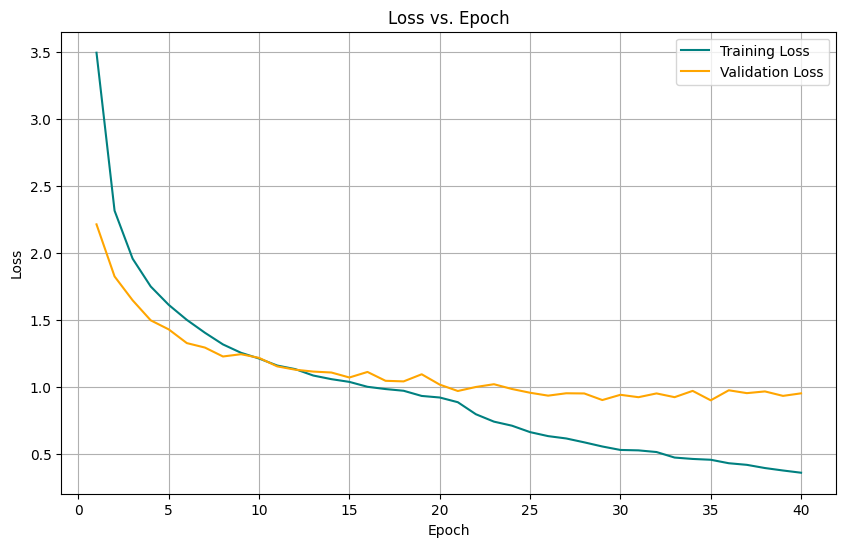

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(full_loss)+1), full_loss, label='Training Loss', color='teal')
plt.plot(range(1, len(full_val_loss)+1), full_val_loss, label='Validation Loss', color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()

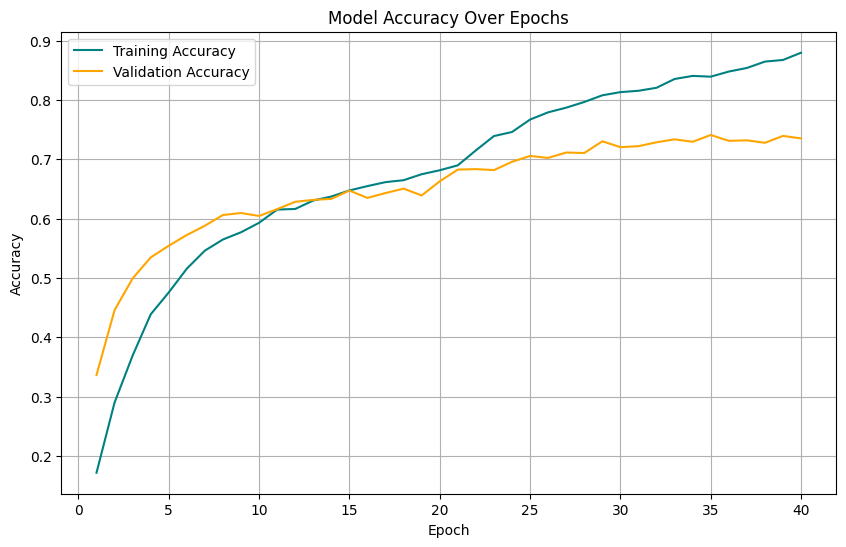

In [7]:
import matplotlib.pyplot as plt

epochs = range(1, len(full_acc) + 1)

# Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, full_acc, label='Training Accuracy', color='teal')
plt.plot(epochs, full_val_acc, label='Validation Accuracy', color='orange')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
new_model = load_model('/content/drive/MyDrive/New Data/model_finetuned_epoch40_2025-05-04_18-20-23.h5')

In [9]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()  # Use CategoricalAccuracy for multi-class

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = new_model.predict(X)

    # Convert y to one-hot encoding for CategoricalAccuracy
    y = tf.keras.utils.to_categorical(y, num_classes=8)

    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print("Precision:", pre.result().numpy())
print("Recall:", re.result().numpy())
print("Accuracy:", acc.result().numpy())

NameError: name 'test' is not defined

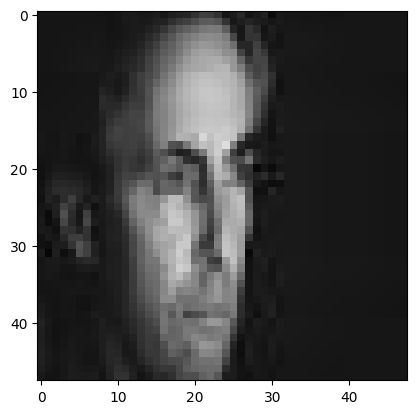

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[[2.1755699e-02 3.2303942e-05 1.7809242e-04 5.7618339e-03 1.1631999e-03
  1.5536498e-03 9.6703523e-01 2.5200276e-03]]
Sadness


In [ ]:
#testing pipeline
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imghdr
test_img = cv2.imread('/content/drive/MyDrive/AI Project Data/sadness/621462.jpg')
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.show()

test_img = cv2.resize(test_img, (256,256))
test_img = test_img/255.0
test_img = np.expand_dims(test_img, 0)
test_predicton = model.predict(test_img)

print(test_predicton)
if np.argmax(test_predicton) == 0:
  print('Anger')
elif np.argmax(test_predicton) == 1:
  print('Contempt')
elif np.argmax(test_predicton) == 2:
  print('Disgust')
elif np.argmax(test_predicton) == 3:
  print('Fear')
elif np.argmax(test_predicton) == 4:
  print('Happy')
elif np.argmax(test_predicton) == 5:
  print('Neutral')
elif np.argmax(test_predicton) == 6:
  print('Sadness')
elif np.argmax(test_predicton) == 7:
  print('Surprise')